<a href="https://colab.research.google.com/github/JiSu0708/ESAA-OB/blob/main/OB_2%EC%A1%B0_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ESAA OB 2조 프로젝트(2)**

[텍스트분석]

월간 데이콘 한국어 문장 관계 분류 AI 경진대회:
https://dacon.io/competitions/official/235875/overview/description

# 1. 패키지 불러오기

In [ ]:
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

!apt-get update -qq
!apt-get install fonts-nanum* -qq

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

matplotlib.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


In [ ]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 36.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from glob import glob
import os
import numpy as np
from tqdm import tqdm, tqdm_notebook

from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

# 2. 데이터 불러오기

In [ ]:
from google import colab
colab.drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/23-2 ESAA OB/data/데이콘_텍스트분석(2)/train_data.csv") #경로 반영
test = pd.read_csv("/content/drive/MyDrive/23-2 ESAA OB/data/데이콘_텍스트분석(2)/test_data.csv")
submission = pd.read_csv("/content/drive/MyDrive/23-2 ESAA OB/data/데이콘_텍스트분석(2)/sample_submission.csv")

In [ ]:
# train 데이터 상단 부분 확인
train.head()

,index,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral


In [ ]:
# train 데이터 구조 파악
print(train.shape)
print(test.shape)
print(submission.shape)

(24998, 4)
(1666, 4)
(1666, 2)


# 3. 데이터 시각화

## 1) Train Target 분포 확인

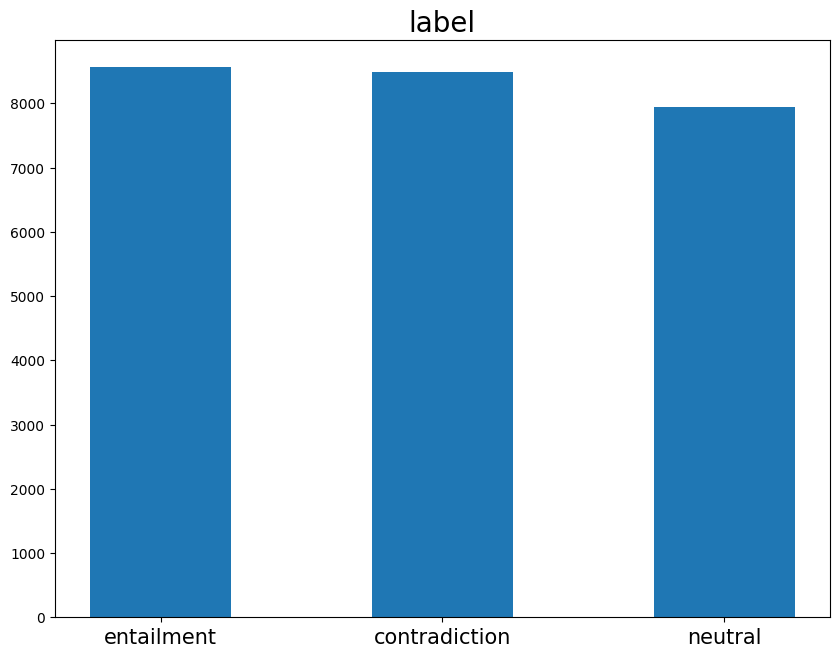

In [ ]:
# 히스토그램을 사용해서 데이터의 분포를 살펴봅니다.
feature = train['label']

plt.figure(figsize=(10,7.5)) # 그래프 이미지 크기 설정

plt.title('label', fontsize=20)
temp = feature.value_counts() # feature 변수의 변수별 개수 계산
plt.bar(temp.keys(), temp.values, width=0.5)
plt.xticks(temp.keys(), fontsize=15)
plt.show()

=> label이 일정하게 분포해 있다.

## 2) 실제 Text와 가설 Text의 평균 길이

In [ ]:
premise_len_mean = np.mean(train['premise'].str.len()) # 리뷰 길이의 평균값 계산
print('실제 Text 평균 길이 :',premise_len_mean)

hypo_len_mean = np.mean(train['hypothesis'].str.len()) # 리뷰 길이의 평균값 계산
print('가설 Text 평균 길이 :',hypo_len_mean)

실제 Text 평균 길이 : 45.406552524201935
가설 Text 평균 길이 : 24.924433954716378


=> 실제 Text의 평균 길이가 가설 Text의 평균 길이보다 길다.

### (1) 실제 Text 확인

In [ ]:
# 데이터 필터링을 위한 마스크 설정 (premise 부분만)
mask_true = (train.label == 'entailment')
mask_false = (train.label == 'contradiction')
mask_neutral = (train.label == 'neutral')

df_train = train.premise.copy()

df_true = train.loc[mask_true,:].premise
df_false = train.loc[mask_false,:].premise
df_neu = train.loc[mask_neutral,:].premise

# 세 집합을 리스트로 묶어줍니다.
compare = [df_train, df_true, df_false, df_neu]

In [ ]:
df_true.head()

2                       이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.
5     이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...
10                       대부분 도보로 이동하기 충분하다는 점이 매력적이었어요.
12                          영화 시작부터 끝까지 긴장감을 늦출 수가 없네요.
16    국토교통부는 연료보조금 지급 근거를 마련하기 위해 올해 하반기에 여객자동차 및 화물...
Name: premise, dtype: object

In [ ]:
df_false.head()

0    씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...
1    삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...
7                           시대상황을 고려하는 현명한 시청태도가 요구되다.
8                    사진과 차이없는 아기자기한 실내소품들과 분위기가 멋졌습니다.
9                           빠른 답장과 간편한 체크인, 깨끗한 집 좋았어요
Name: premise, dtype: object

In [ ]:
df_neu.head()

3     광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...
4     진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...
6            자신뿐만 아니라 남을 돕고자 하는 청년의 꿈과 열정에 모두가 주목하고 있다.
11     오후에는 소흘읍민의 멋진 끼를 엿볼 수 있는 호수둘레길 버스킹 공연이 연이어 진행된다.
15                                상당히 많은 것을 내포하고 있는 영화.
Name: premise, dtype: object

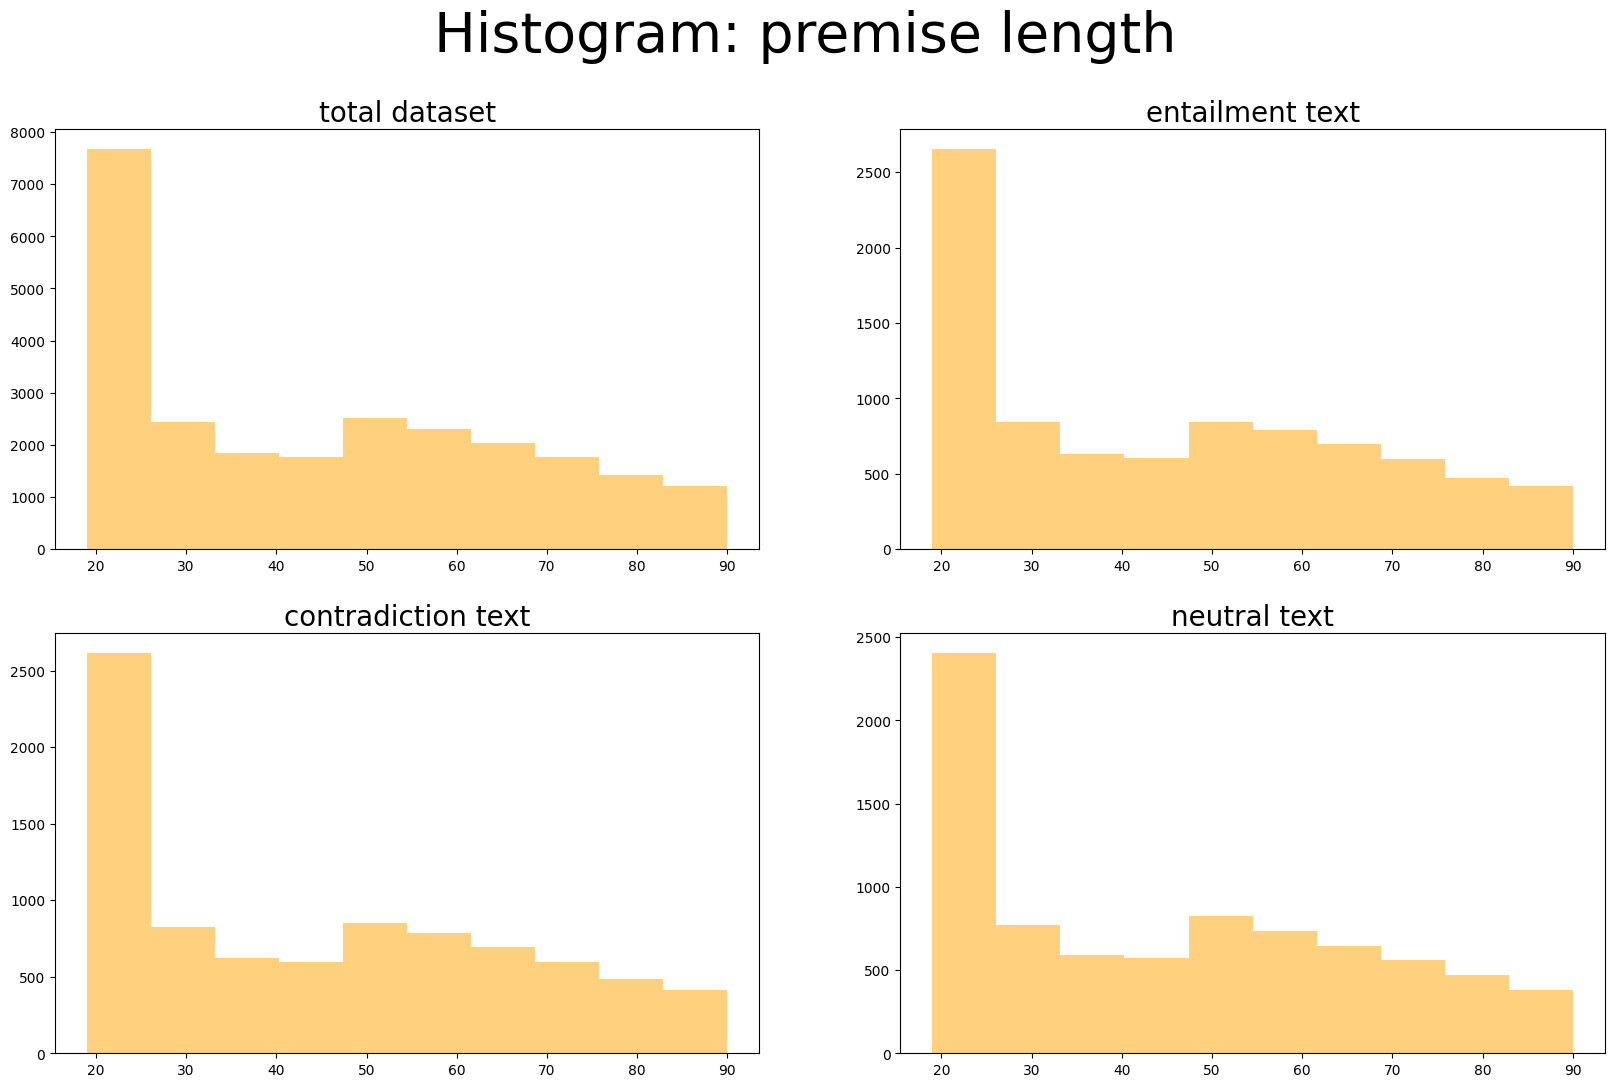

In [ ]:
# 히스토그램을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(20,12))
plt.suptitle("Histogram: premise length", fontsize=40)
name = ['total dataset', 'entailment text', 'contradiction text', 'neutral text']

for i in range(len(compare)):
    document = compare[i]
    string_len = [len(x) for x in document]
    # print(string_len)
    plt.subplot(2, 2, i+1)
    plt.title(name[i], fontsize=20)
    plt.hist(string_len, alpha=0.5, color='orange')

plt.show()

=> premise text의 경우 대부분 20~30자 사이에 분포해있고 최대 90자 정도까지 일정한 수치만큼 분포해 있다.

=> 실제 text인 premise는 label 값에 관계없이 동일 히스토그램을 보여주고 있다.

### (2) 가설 text 확인

In [ ]:
# 데이터 필터링을 위한 마스크 설정 (Hypothesis 부분만)
mask_true = (train.label == 'entailment')
mask_false = (train.label == 'contradiction')
mask_neutral = (train.label == 'neutral')

df_train = train.hypothesis .copy()

df_true = train.loc[mask_true,:].hypothesis
df_false = train.loc[mask_false,:].hypothesis
df_neu = train.loc[mask_neutral,:].hypothesis

# 세 집합을 리스트로 묶어줍니다.
compare = [df_train, df_true, df_false, df_neu]

In [ ]:
df_true.head()

2     예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.
5         코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.
10                            대부분 걸어서 갈수 있어요.
12                        영화 시작부터 긴장감이 함께하네요.
16      여객자동차 및 화물자동차 운수사업법을 국토교통부가 개정할 계획이다.
Name: hypothesis, dtype: object

In [ ]:
df_false.head()

0                       씨름의 여자들의 놀이이다.
1                     자작극을 벌인 이는 3명이다.
7                   시청태도에 특별한 주의점은 없다.
8    아기자기한 실내소품들은 사진에서 본 것과 차이가 있었습니다.
9                          체크인이 복잡했어요.
Name: hypothesis, dtype: object

In [ ]:
df_neu.head()

3                      원주민들은 종합대책에 만족했다.
4     이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.
6                  모든 청년은 꿈과 열정을 가지고 있다.
11           호수둘레길 버스킹 공연에 많은 군민들이 참석했다.
15            인간의 감정에 대한 내용을 내포하고 있는 영화.
Name: hypothesis, dtype: object

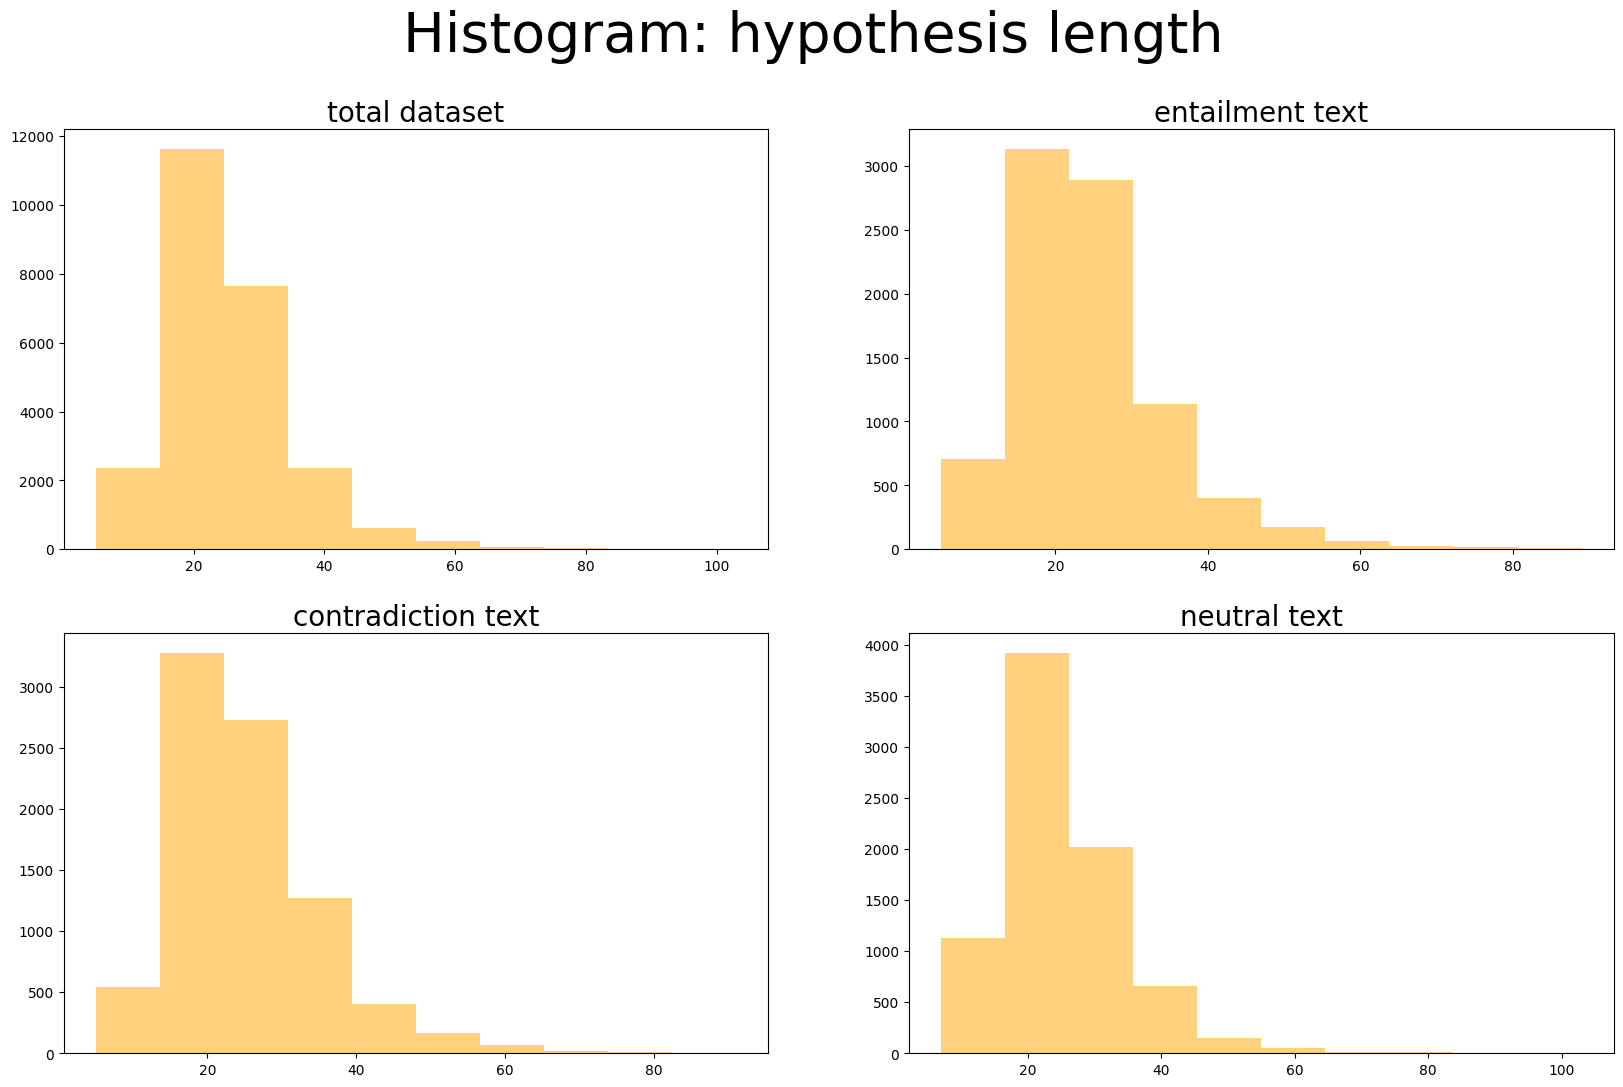

In [ ]:
# 히스토그램을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(20,12))
plt.suptitle("Histogram: hypothesis length", fontsize=40)
name = ['total dataset', 'entailment text', 'contradiction text', 'neutral text']

for i in range(len(compare)):
    document = compare[i]
    string_len = [len(x) for x in document]
    plt.subplot(2, 2, i+1)
    plt.title(name[i], fontsize=20)
    plt.hist(string_len, alpha=0.5, color='orange')

plt.show()

=> 가설 text는 label 값에 따라 어느 정도 차이를 보여주지만 역시 20자 정도에 많이 분포해 있는 모습이다.

=> 알 수 없는 문장은 참, 거짓에 비해 상대적으로 적은 양을 가지고도 가설 문장의 참/거짓/알수없다를 판별해내야 한다.


## 3) Word Cloud

In [ ]:
def df2str(df):
    # 전체 리뷰들을 하나의 문자열로 만듦
    s = [s for s in df]
    document = ""
    for i in range(len(s)):
        document += s[i]
    return document

def get_noun(text):
    # okt tagger를 이용해 명사 추출
    okt = Okt()
    noun = okt.nouns(text)
    for i,v in enumerate(noun):
        if len(v)<2:
            noun.pop(i)
    count = Counter(noun)
    noun_list = count.most_common(100)

    return noun_list

def visualize(noun_list, title):
    # 워드클라우드 이미지 생성
    wc= WordCloud(
        background_color='white', # 배경 색깔 정하기
        colormap = 'Dark2', # 폰트 색깔 정하기
        font_path = font_path,
        width = 800,
        height = 800).generate_from_frequencies(dict(noun_list))

    plt.figure(figsize=(10,10)) # 이미지 사이즈 지정
    plt.title(title, fontsize=20)
    plt.imshow(wc, interpolation='lanczos') # 이미지의 부드럽기 정도
    plt.axis('off') # x y 축 숫자 제거
    plt.show()  # 워드클라우드 이미지 확인

    return wc

In [ ]:
document = df2str(df_train) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10]

[('영화', 2053),
 ('숙소', 713),
 ('사람', 539),
 ('호스트', 443),
 ('위치', 421),
 ('사업', 401),
 ('대한', 342),
 ('가장', 336),
 ('지원', 328),
 ('예정', 316)]

## 1) Total_text

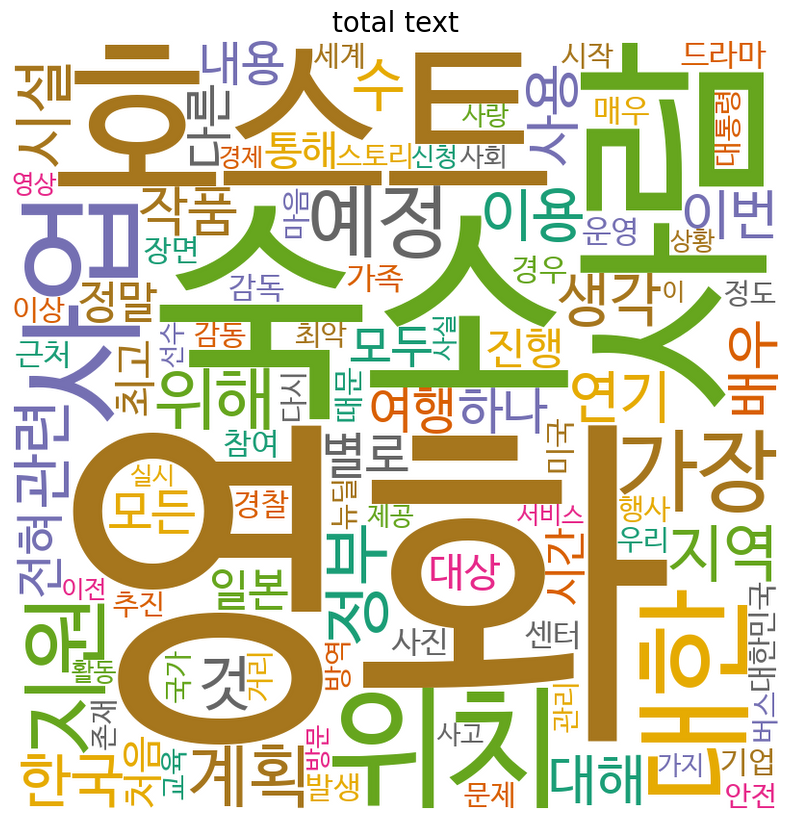

In [ ]:
total_text = visualize(noun_list,'total text') # 워드클라우드 시각화

=> 가설 문장의 참/거짓을 확인하기 어려움.

=> 영화가 크게 있는 걸 보면 영화 기사나 리뷰 글에서 나온 문장들도 있는 건가 궁금하다.

=> 전체적으로 Word Cloud 실행


## 2) Entailment
- Premise text를 label에 따라 Word Cloud

In [ ]:
# Entailment
document = df2str(df_true) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10]

[('영화', 700),
 ('숙소', 244),
 ('사람', 182),
 ('위치', 169),
 ('사업', 149),
 ('호스트', 146),
 ('위해', 122),
 ('지원', 122),
 ('시설', 111),
 ('수', 108)]

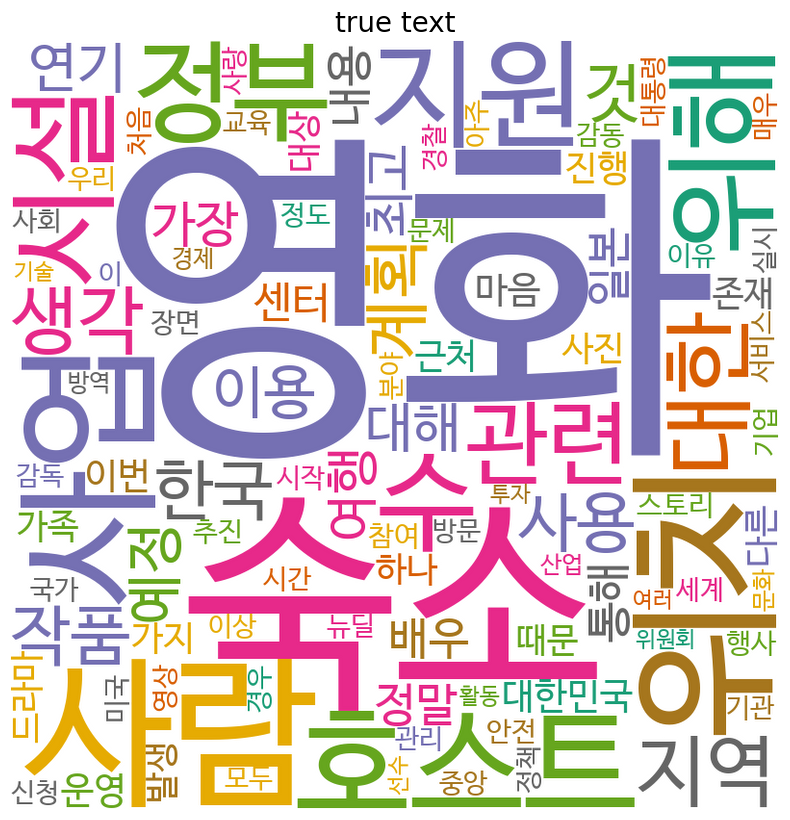

In [ ]:
true_text = visualize(noun_list,'true text') # 워드클라우드 시각화

=> 라벨 구분 없이 Word Cloud를 진행했을 때랑 비슷한 형태가 나온다.

=> 숙소, 사업, 위치, 호스트, 영화 이런 단어들은 제외해도 될 것 같다.

## 3) Contradiction

In [ ]:
# Contradiction
document = df2str(df_false) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10]

[('영화', 700),
 ('숙소', 238),
 ('전혀', 198),
 ('사람', 181),
 ('별로', 165),
 ('위치', 146),
 ('호스트', 144),
 ('사업', 142),
 ('관련', 130),
 ('대한', 126)]

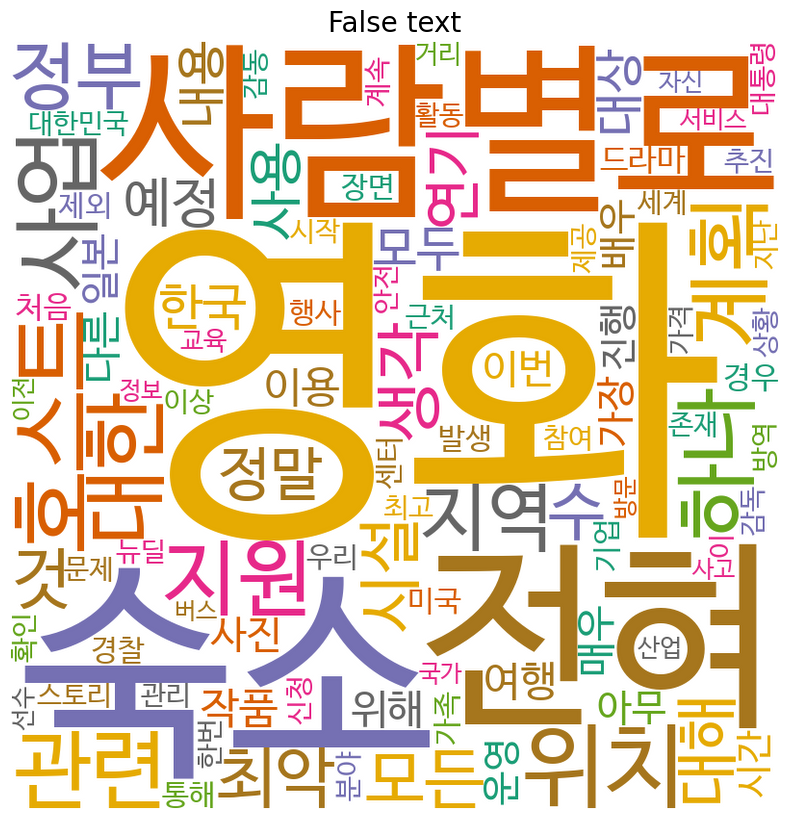

In [ ]:
false_text = visualize(noun_list,'False text') # 워드클라우드 시각화

=> 가설이 참인 문장을 워드클라우드 했을 때와 비슷한 형태인 것으로 보여진다.

## 4) Neutral

In [ ]:
# Neutral
document = df2str(df_neu) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10]

[('영화', 653),
 ('숙소', 231),
 ('가장', 192),
 ('사람', 176),
 ('호스트', 153),
 ('예정', 140),
 ('위해', 113),
 ('대한', 110),
 ('사업', 110),
 ('위치', 106)]

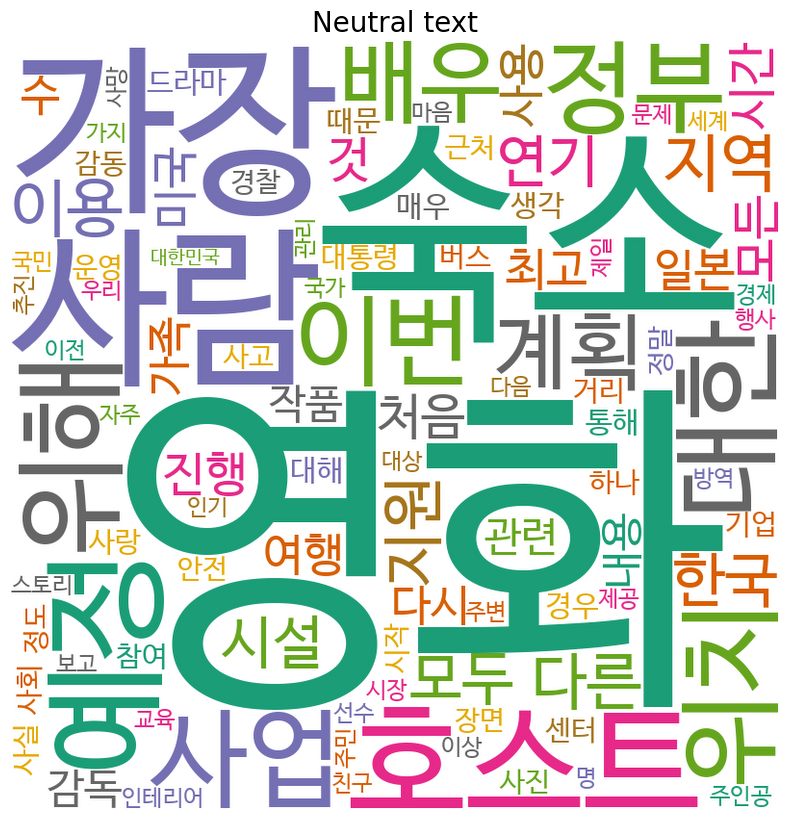

In [ ]:
neutral_text = visualize(noun_list,'Neutral text') # 워드클라우드 시각화

## 5) Hypothesis text를 label에 따라 Word Cloud

### (1) Entailment

In [ ]:
df_hy_train = train.hypothesis.copy()

df_hy_true = train.loc[mask_true,:].hypothesis
df_hy_false = train.loc[mask_false,:].hypothesis
df_hy_neu = train.loc[mask_neutral,:].hypothesis

In [ ]:
document = df2str(df_hy_true) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10]

[('영화', 700),
 ('숙소', 244),
 ('사람', 182),
 ('위치', 169),
 ('사업', 149),
 ('호스트', 146),
 ('위해', 122),
 ('지원', 122),
 ('시설', 111),
 ('수', 108)]

### (2) Contradiction

In [ ]:
document = df2str(df_hy_false) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10]

[('영화', 700),
 ('숙소', 238),
 ('전혀', 198),
 ('사람', 181),
 ('별로', 165),
 ('위치', 146),
 ('호스트', 144),
 ('사업', 142),
 ('관련', 130),
 ('대한', 126)]

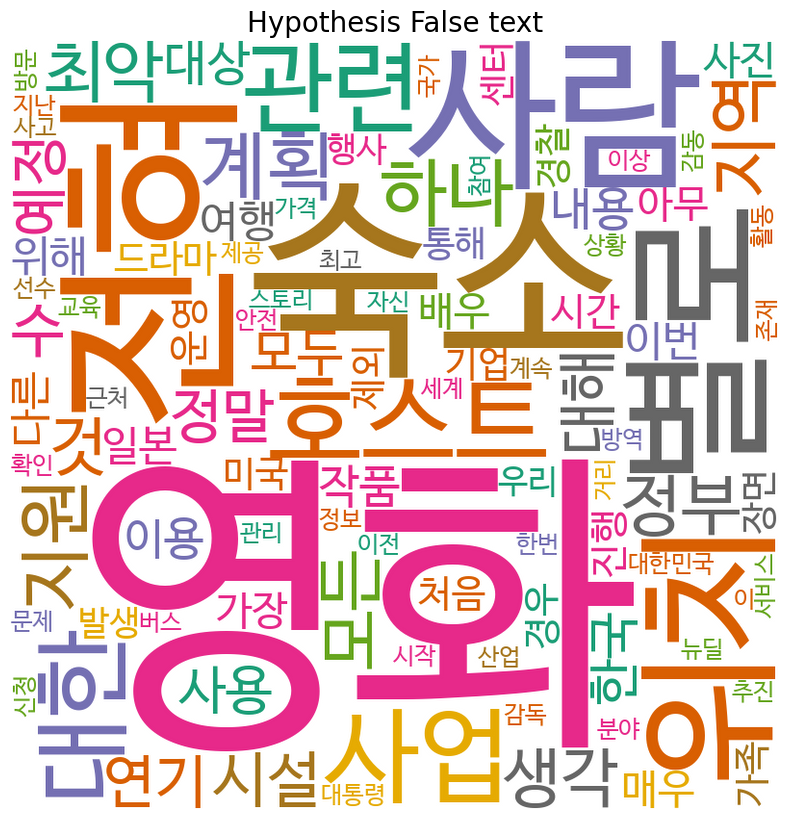

In [ ]:
false_text = visualize(noun_list,'Hypothesis False text') # 워드클라우드 시각화

### (3) Neutral

In [ ]:
document = df2str(df_hy_neu) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10]

[('영화', 653),
 ('숙소', 231),
 ('가장', 192),
 ('사람', 176),
 ('호스트', 153),
 ('예정', 140),
 ('위해', 113),
 ('대한', 110),
 ('사업', 110),
 ('위치', 106)]

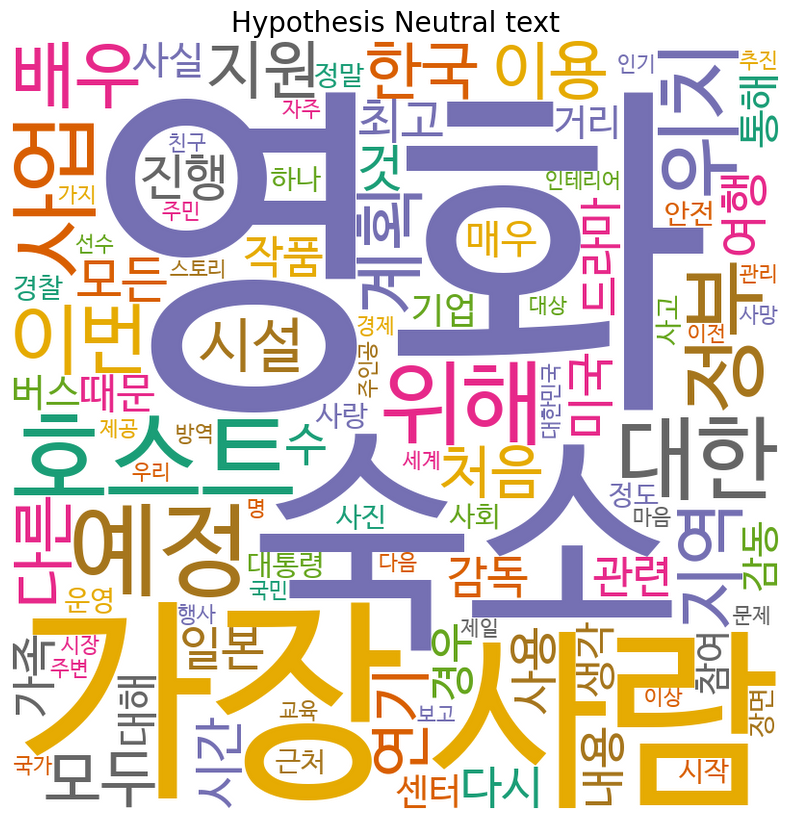

In [ ]:
neutral_text = visualize(noun_list,'Hypothesis Neutral text') # 워드클라우드 시각화